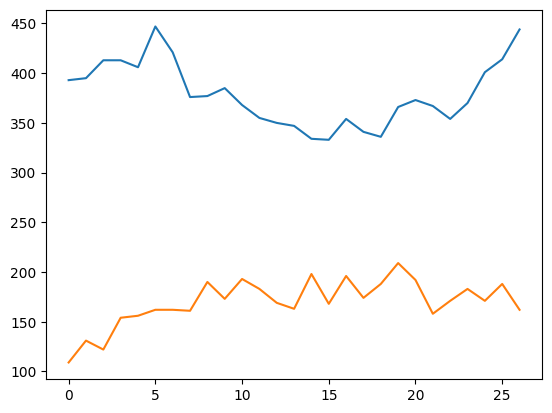

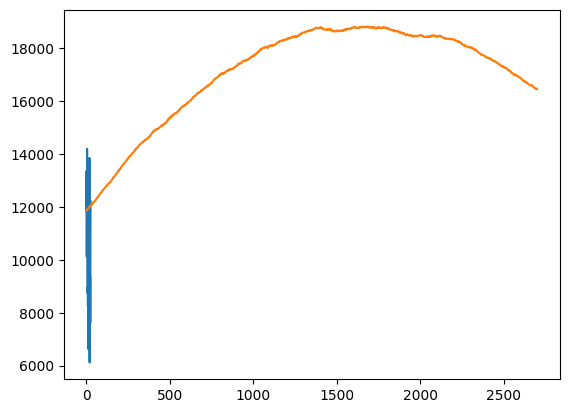

In [1]:
import numpy as np
from scipy.stats import nbinom
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp,odeint
import sys
import pandas as pd

rng = np.random.default_rng()

predicted_beta = pd.read_csv('../datasets/out_logit-beta_trj_bootp.csv')
observations = pd.read_csv('../datasets/AZ_FLU_HOSPITALIZATIONS.csv').to_numpy()
observations = np.delete(observations,0,1)
estimated_state = pd.read_csv('../datasets/ESTIMATED_HOSP.csv').to_numpy()
estimated_state = np.delete(estimated_state,0,1)


def beta(t): 
    return float(predicted_beta.iloc[50,t])

params={
"beta":beta,
"gamma":0.1,
"eta":0.1,
"std":10,
"R":1/10,
"hosp":15,
"L":90,
"D":10}
    
def RHS(rng,state,param:dict,tau:float,t:int):
    S,I,R,H = state
    N = S+I+R+H
    new_susceptibles = rng.poisson(((1/param['L'])*R) * tau)
    new_infected = rng.poisson((((param['beta'](t) * S * I)/N)) * tau)
    new_recovered_from_H = rng.poisson(((1/param['hosp']) * H) * tau)
    new_recovered_from_I = rng.poisson((((1/param['D']) * (1-param['gamma']))*I)*tau) 
    new_hospitalized = rng.poisson(((1/param['D']) * param['gamma'] * I)*tau)
        

    state = np.zeros_like(state)
    '''Enforces the minimum will be 0'''
    state[0] = max(0.,S-new_infected + new_susceptibles)
    state[1] = max(0.,I + new_infected - (new_hospitalized + new_recovered_from_I))
    state[2] = max(0.,R + new_recovered_from_H + new_recovered_from_I - new_susceptibles)
    state[3] = max(0.,H + new_hospitalized - new_recovered_from_H)

    return state,new_hospitalized

states = [estimated_state[60]]
obvs = np.zeros(27)
tau = 1/100
for t in range(27): 
    for _ in range(int(1/tau)):
        new_state,new_hospitalized = RHS(rng,states[-1],params,tau,t)
        states.append(new_state)
        obvs[t] += new_hospitalized

labels = ['S','I','R','H']



plt.plot(observations[60:87])
plt.plot(obvs)
plt.show()

states = np.array(states)
plt.plot(estimated_state[60:87,1])
plt.plot(states[:,1])
plt.show()

    




